In [1]:
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt;
import time
import backtrader as bt
from datalib import get_data
import pickle 
outfile = open("data/df.pkl",'rb')

instruments = [
    #'VGLT-STK-ARCA',
    'VOO-STK-ARCA',
    'VOX-STK-ARCA',
    'VCR-STK-ARCA',
    'VDC-STK-ARCA',
    'VDE-STK-ARCA',
    'VFH-STK-ARCA',
    'VHT-STK-ARCA',
    'VIS-STK-ARCA',
    'VGT-STK-ARCA',
    'VAW-STK-ARCA',
    'VNQ-STK-ARCA',
    'VPU-STK-ARCA',
]

dfs_ = pickle.load(outfile)

In [2]:
# silence pandas warning to make this feel like rl
pd.set_option('mode.chained_assignment', None)

## Input Features

In [3]:
dfs = 1*dfs_
for L in [7,22,63]:
    bb_maxs = []
    bb_mins = []
    for inst in instruments:
        df = 1*dfs.loc[inst]
        burnin = 10
        bb_max = [0]*burnin
        bb_min = [0]*burnin
        alpha = 0
        X = df['close'].ewm(com=alpha).mean()
        for i in range(burnin,len(X)):
            e = i 
            s = max(0,i-L)
            slope = (X[e] - X[s]) / (e-s)
            residual = X[s:e+1]-(X[s]+np.arange(e-s +1)*slope)
            bb_max.append(residual.max())
            bb_min.append(residual.min())
        bb_maxs.append(np.log((bb_max + X).values))
        bb_mins.append(np.log((bb_min + X).values))
    dfs[f"bb_max_{L}"] = np.array(bb_maxs).reshape(-1)
    dfs[f"bb_min_{L}"] = np.array(bb_maxs).reshape(-1)

In [4]:
dfs["x"] = np.log(dfs["close"])
dfs["r"] = dfs["x"]-dfs["x"].groupby("asset").shift(1).fillna(method="bfill")
ws = [5,12,22]
signals = {}
for w in ws:
    signals[f"r_volvol_{w}"] = dfs['r'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).std().fillna(0).rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"r_mean_{w}"] = dfs['r'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).mean())
    signals[f"r_std_{w}"] = dfs['r'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"r_stdp_{w}"] = dfs['r'].groupby('asset').apply(lambda x: ((x>0)*x).rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"r_stdn_{w}"] = dfs['r'].groupby('asset').apply(lambda x: ((x<0)*x).rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"r_skew_{w}"] = dfs['r'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).skew().fillna(0))
    signals[f"r_kurt_{w}"] = dfs['r'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).kurt().fillna(0))
    signals[f"v_{w}"] = dfs['volume']/dfs['volume'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).mean())
    signals[f"b_min_{w}"] = dfs['x'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).min())
    signals[f"b_max_{w}"] = dfs['x'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).max())
    signals[f"bl_min_{w}"] = dfs['x'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).mean()-2*x.rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"bl_max_{w}"] = dfs['x'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).mean()+2*x.rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"bl4_min_{w}"] = dfs['x'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).mean()-4*x.rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"bl4_max_{w}"] = dfs['x'].groupby('asset').apply(lambda x: x.rolling(window=w,min_periods=1).mean()+4*x.rolling(window=w,min_periods=1).std().fillna(0))
    signals[f"target_max_{w}"] = dfs["x"].groupby('asset').apply(
        lambda x: x.shift(-1*(w-1)).rolling(w,min_periods=1).max())
    signals[f"target_min_{w}"] = dfs["x"].groupby('asset').apply(
        lambda x: x.shift(-1*(w-1)).rolling(w,min_periods=1).min())
dfs = dfs.join(pd.DataFrame(signals))
signals_ = signals

## Model

In [5]:
import tensorflow as tf
tf.enable_eager_execution();

/home/santiago_perez_lastra/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/santiago_perez_lastra/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/santiago_perez_lastra/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/santiago_perez_lastra/.local/lib/python3

In [6]:
import itertools
f_sigs = list(itertools.chain.from_iterable([[f"v_{w}",f"r_volvol_{w}",f"r_mean_{w}",f"r_std_{w}",f"r_skew_{w}",f"r_kurt_{w}"] for w in ws]))
f_base = ["x"]+ ['bb_max_7',"bb_min_7",'bb_max_22',"bb_min_22","bb_max_63","bb_min_63"]+ list(itertools.chain.from_iterable([[f"b_min_{w}",f"b_max_{w}",f"bl_min_{w}",f"bl_max_{w}",f"b_max_{w}",f"bl4_min_{w}",f"bl4_max_{w}"] for w in ws]))
f_target = ["target_max_12","target_min_12"]

In [7]:
X_s = np.array([[1*dfs[f_][inst] for f_ in f_sigs] for inst in instruments]).transpose(2,0,1).astype(np.float32);
X_b = np.array([[1*dfs[f_][inst] for f_ in f_base] for inst in instruments]).transpose(2,0,1).astype(np.float32);
Y   = np.array([[1*dfs[f_][inst] for f_ in f_target] for inst in instruments]).transpose(2,0,1).astype(np.float32);

In [8]:
X_s.shape,X_b.shape,Y.shape

((1521, 12, 18), (1521, 12, 28), (1521, 12, 2))

In [9]:
X_pos = []
for i in range(X_s.shape[1]):
    X_pos.append(np.hstack([X_s[:,i,:],np.array([np.eye(X_s.shape[1])[i]]*X_s.shape[0])]))
X_pos = np.array(X_pos).astype(np.float32)

In [10]:
test_length = 400 #int(X_s.shape[0]*0.25)

In [11]:
signals = tf.keras.layers.Input(shape=(X_s.shape[1],X_s.shape[2]))
base = tf.keras.layers.Input(shape=(X_b.shape[1],X_b.shape[2]))
def OneLayer(signals):
    L1 = 10
    L2 = 10

    d = 0.05
    n_heads = 1
    outs = []
    for head in range(n_heads):
        h = tf.keras.layers.Dense(L1,activation='tanh')(signals)
        h = tf.keras.layers.Dropout(d)(h)
        h = tf.keras.layers.Dense(L2,activation='tanh')(h)
        h = tf.keras.layers.Dropout(d)(h)
        hidden = tf.keras.layers.Dense(X_s.shape[2])(h)

        q = tf.keras.layers.Dense(L1,activation='tanh')(hidden)
        q = tf.keras.layers.Dropout(d)(q)
        q = tf.keras.layers.Dense(L2,activation='tanh')(q)
        q = tf.keras.layers.Dropout(d)(q)
        query = tf.keras.layers.Dense(X_s.shape[2])(q)

        k = tf.keras.layers.Dense(L1,activation='tanh')(hidden)
        k = tf.keras.layers.Dropout(d)(k)
        k = tf.keras.layers.Dense(L2,activation='tanh')(k)
        k = tf.keras.layers.Dropout(d)(k)
        key = tf.keras.layers.Dense(X_s.shape[2])(k)

        v = tf.keras.layers.Dense(L1,activation='tanh')(hidden)
        v = tf.keras.layers.Dropout(d)(v)
        v = tf.keras.layers.Dense(L2,activation='tanh')(v)
        v = tf.keras.layers.Dropout(d)(v)
        value = tf.keras.layers.Dense(X_s.shape[2])(v)

        scores = tf.einsum("tqf,tkf->tqk",query, key)
        distribution = tf.nn.softmax(scores, axis=-1)
        #outs.append(tf.einsum("tkv,tvf->tkf",distribution,hidden))
        outs.append(tf.einsum("tkv,tvf->tkf",distribution,value))

    return tf.math.add_n(outs)
        
    #return modulated #+signals

x = signals 
for i in range(2):
    x = OneLayer(x)

w = tf.reshape(tf.keras.layers.Dense(X_b.shape[2]*Y.shape[2])(x), [-1,X_b.shape[1],X_b.shape[2],Y.shape[2]])
w = tf.nn.softmax(w,axis=2)
#b = tf.keras.layers.Dense(Y.shape[2])(x)

out = tf.einsum("tabo,tab->tao",w,base)# + b
model = tf.keras.Model(inputs=[signals,base], outputs=out)

In [12]:
model.compile(
  loss=tf.keras.losses.MSE,
  optimizer=tf.keras.optimizers.Adam(lr=0.01),
  metrics=["MSE"],
)

In [13]:
test_scores = model.evaluate([X_s[-test_length:,:,:],X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 1s - loss: 0.0049 - mean_squared_error: 0.0049
Test MSE: 0.004886652437271551
Test MSE: 0.004886653


In [14]:
model.fit([X_s[:-test_length,:,:],X_b[:-test_length,:,:]], Y[:-test_length,:,:], batch_size=5, epochs=20, validation_split=0.1)

Train on 1008 samples, validate on 113 samples
Epoch 1/20
1008/1008 [==============================] - 7s 7ms/sample - loss: 5.6713e-04 - mean_squared_error: 5.6713e-04 - val_loss: 5.4165e-04 - val_mean_squared_error: 5.4165e-04
Epoch 2/20
1008/1008 [==============================] - 1s 1ms/sample - loss: 5.3285e-04 - mean_squared_error: 5.3285e-04 - val_loss: 5.3069e-04 - val_mean_squared_error: 5.3069e-04
Epoch 3/20
1008/1008 [==============================] - 1s 1ms/sample - loss: 5.2583e-04 - mean_squared_error: 5.2583e-04 - val_loss: 4.7417e-04 - val_mean_squared_error: 4.7417e-04
Epoch 4/20
1008/1008 [==============================] - 2s 2ms/sample - loss: 5.1679e-04 - mean_squared_error: 5.1679e-04 - val_loss: 4.4306e-04 - val_mean_squared_error: 4.4306e-04
Epoch 5/20
1008/1008 [==============================] - 1s 1ms/sample - loss: 5.1337e-04 - mean_squared_error: 5.1337e-04 - val_loss: 4.6168e-04 - val_mean_squared_error: 4.6168e-04
Epoch 6/20
1008/1008 [=====================

In [15]:
#just attention,value transform, multihead=4,stn+stdp , v_stats, r_stats,volvol, [5,22,63],bb[7,22,63] n=10,10 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Test MSE: 0.0022566385421669112
Test MSE: 0.0022566384


In [15]:
#just attention,value transform, multihead=4,stn+stdp , v_stats, r_stats,volvol, [5,22,63],bb[7,22,63] n=10,10 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Test MSE: 0.005628058584406972
Test MSE: 0.0056280587


In [15]:
#just attention,value transform, multihead=4,stn+stdp , v_stats, r_stats,volvol, [5,22,63],bb[7,22,63] n=10,10 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0066 - mean_squared_error: 0.0066
Test MSE: 0.0066273533669300375
Test MSE: 0.0066273534


In [15]:
#just attention,value transform, multihead=4,stn+stdp , v_stats, r_stats,volvol, [5,22,63],bb[7,22,63] n=10,10 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0140 - mean_squared_error: 0.0140
Test MSE: 0.014029065100476145
Test MSE: 0.014029066


In [15]:
#just attention,value transform, multihead=3,stn+stdp , v_stats, r_stats,volvol, [5,15,22,30],bb[7,22,63] n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Test MSE: 0.005919997957535088
Test MSE: 0.005919998


In [18]:
#just attention,value transform, multihead=3,stn+stdp , v_stats, r_stats,volvol, [5,22] ,bb[7,22,63] n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.005465057485271246
Test MSE: 0.0054650577


In [29]:
#just attention,value transform, multihead=3,v_stats, r_stats,volvol, [5,22] ,bb[7,22,63] n=10,20 50 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.00550719887833111
Test MSE: 0.0055071986


In [15]:
#just attention,value transform, multihead=3,v_stats, r_stats,volvol, [5,22] ,bb[7,22,63] n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.00549898985424079
Test MSE: 0.0054989904


In [19]:
#just attention,value transform, multihead=3,v_stats, r_stats, [5,22] ,bb[7,22,63] n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.00552944497205317
Test MSE: 0.0055294456


In [33]:
#just attention,value transform, multihead=4,v_stats, r_stats, [5,22] , n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Test MSE: 0.00558202278567478
Test MSE: 0.005582023


In [16]:
#just attention,value transform, multihead=3,v_stats, r_stats, [5,22] , n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Test MSE: 0.00571034719934687
Test MSE: 0.005710347


In [21]:
#just attention,value transform, multihead=3,v_stats, r_stats, [5,22] , n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0056 - mean_squared_error: 0.0056
Test MSE: 0.0055525777663569895
Test MSE: 0.005552578


In [16]:
#just attention,value transform, multihead=3,v_stats, r_stats, [5,22] , n=10,20 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.005538308481918648
Test MSE: 0.0055383085


In [28]:
#just attention,value transform, multihead=3,v_stats, r_stats, [5,22] , n=20,10, 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.005480871647596359
Test MSE: 0.0054808715


In [19]:
#just attention,value transform, multihead=3,v_stats, r_stats, [5,22] , n=20,10, 25 epochs
test_scores = model.evaluate([X_s[-test_length:,:,:], X_b[-test_length:,:,:]], Y[-test_length:,:,:], verbose=2)
print("Test MSE:", test_scores[0])
print("Test MSE:", test_scores[1])

400/400 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Test MSE: 0.005467837578617036
Test MSE: 0.0054678377


In [16]:
nn= np.array(model([X_s,X_b]));

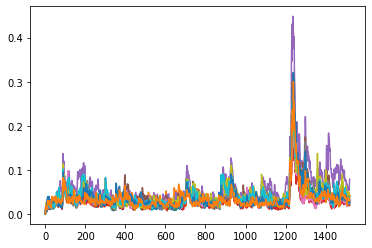

In [17]:
plt.plot(nn[:,:,0]-nn[:,:,1])

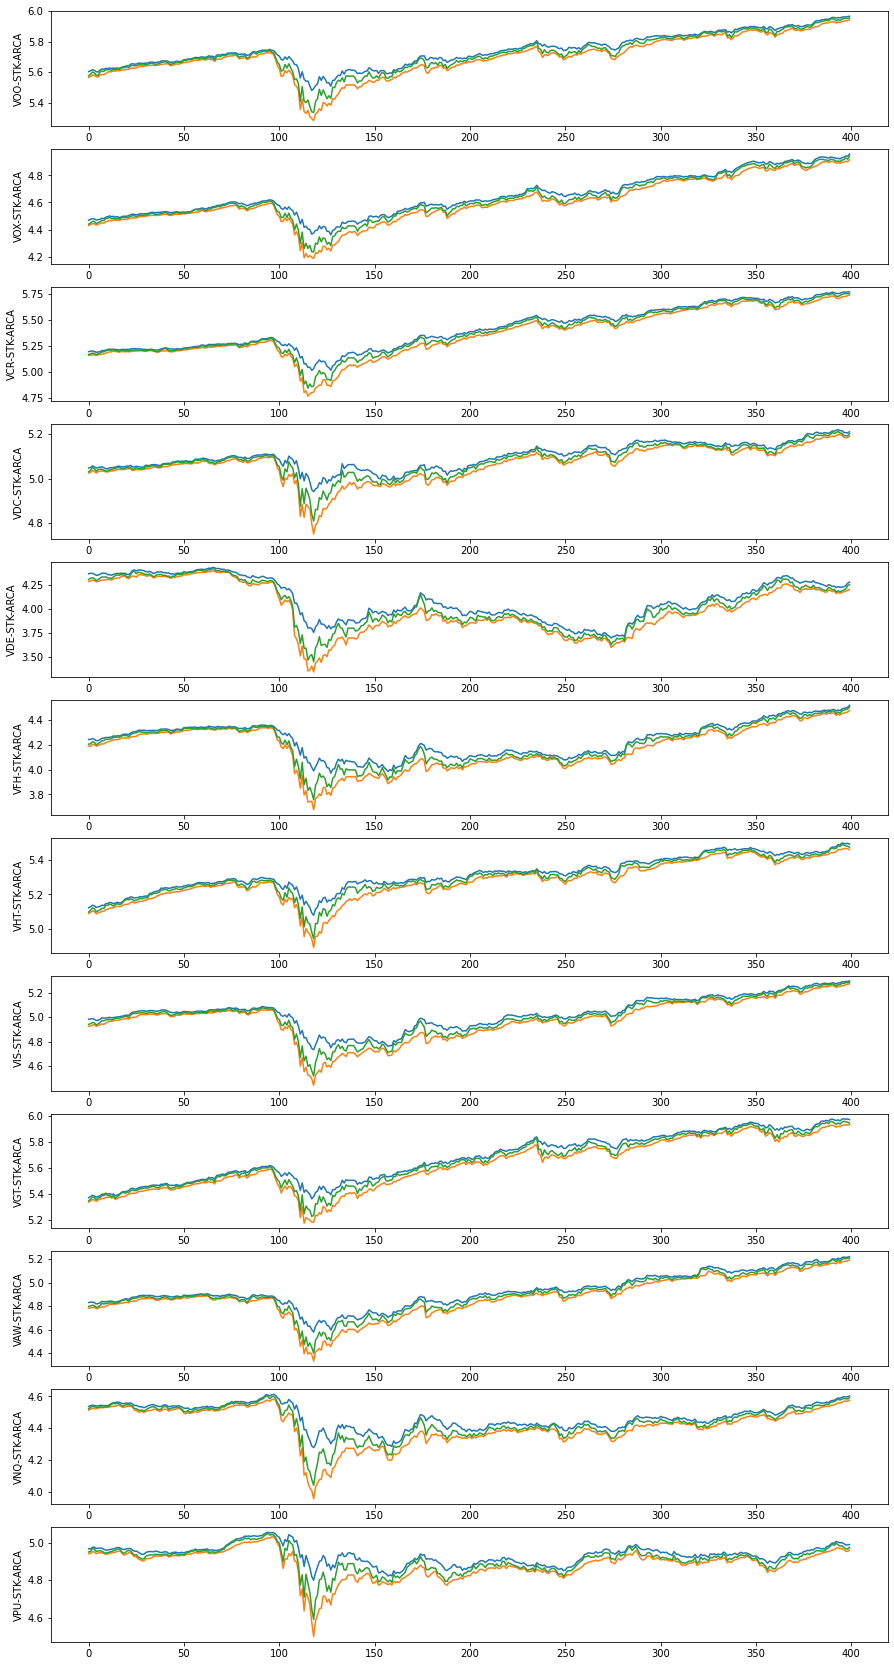

In [18]:
plt.figure(figsize=(15,30))
N = len(instruments)
n_tail=400
for i in range(N):
    plt.subplot(N,1,i+1)
    plt.ylabel(instruments[i]);
    #plt.plot(Y[-n_tail:,i,0])
    #plt.plot(Y[-n_tail:,i,1])

    plt.plot(nn[-n_tail:,i,0])
    plt.plot(nn[-n_tail:,i,1])
    plt.plot(X_b[-n_tail:,i,0])
plt.show()

In [19]:
c = X_b[-test_length:,:,0]
r = c[1:,:]-c[:-1,:]
C = r.transpose().dot(r)

In [20]:
s = np.clip(np.nan_to_num((nn[:,:,1]-X_b[:,:,0])/(nn[:,:,1]-nn[:,:,0])),0,1)

/home/santiago_perez_lastra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [21]:
w = s.dot(np.linalg.inv(C))
w = w/w.sum(1).reshape(-1,1)

In [22]:
#plt.plot(np.cumsum(w[:-1,:]*r,0).sum(1))

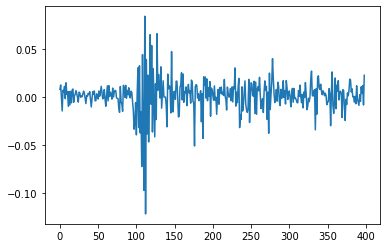

In [23]:
r = c[1:,:]-c[:-1,:]
plt.plot(r[:,1])

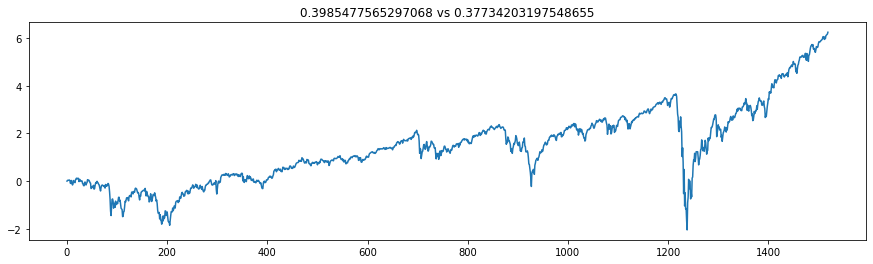

In [24]:
c = X_b[:,:,0]
r = c[1:,:]-c[:-1,:]
sharpe = lambda dd : (252**0.5)*(dd.mean()/dd.std())
rets = r*(s[:-1,:]<0.7)#*(s[:-1,:]>0.05)
plt.figure(figsize=(15,4))
plt.title(f"{sharpe(rets)} vs {sharpe(r)}");
plt.plot(np.cumsum(rets,0).sum(1));

In [25]:
s

array([[1.        , 0.        , 0.5       , ..., 1.        , 0.        ,
        1.        ],
       [0.62527645, 0.77365494, 0.77410024, ..., 0.6254866 , 0.774072  ,
        0.62546396],
       [0.81073904, 0.8127535 , 0.8091826 , ..., 0.6845916 , 0.7878208 ,
        0.6740232 ],
       ...,
       [0.6013256 , 0.62135464, 0.63840985, ..., 0.6632207 , 0.5830497 ,
        0.36574283],
       [0.5495604 , 0.46985468, 0.5465444 , ..., 0.6677377 , 0.5084579 ,
        0.35595632],
       [0.48534003, 0.6430139 , 0.4067406 , ..., 0.55396605, 0.5978402 ,
        0.49029213]], dtype=float32)

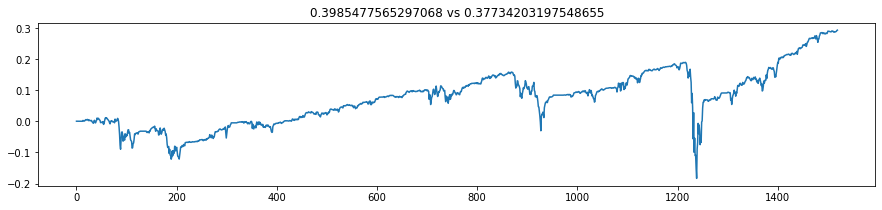

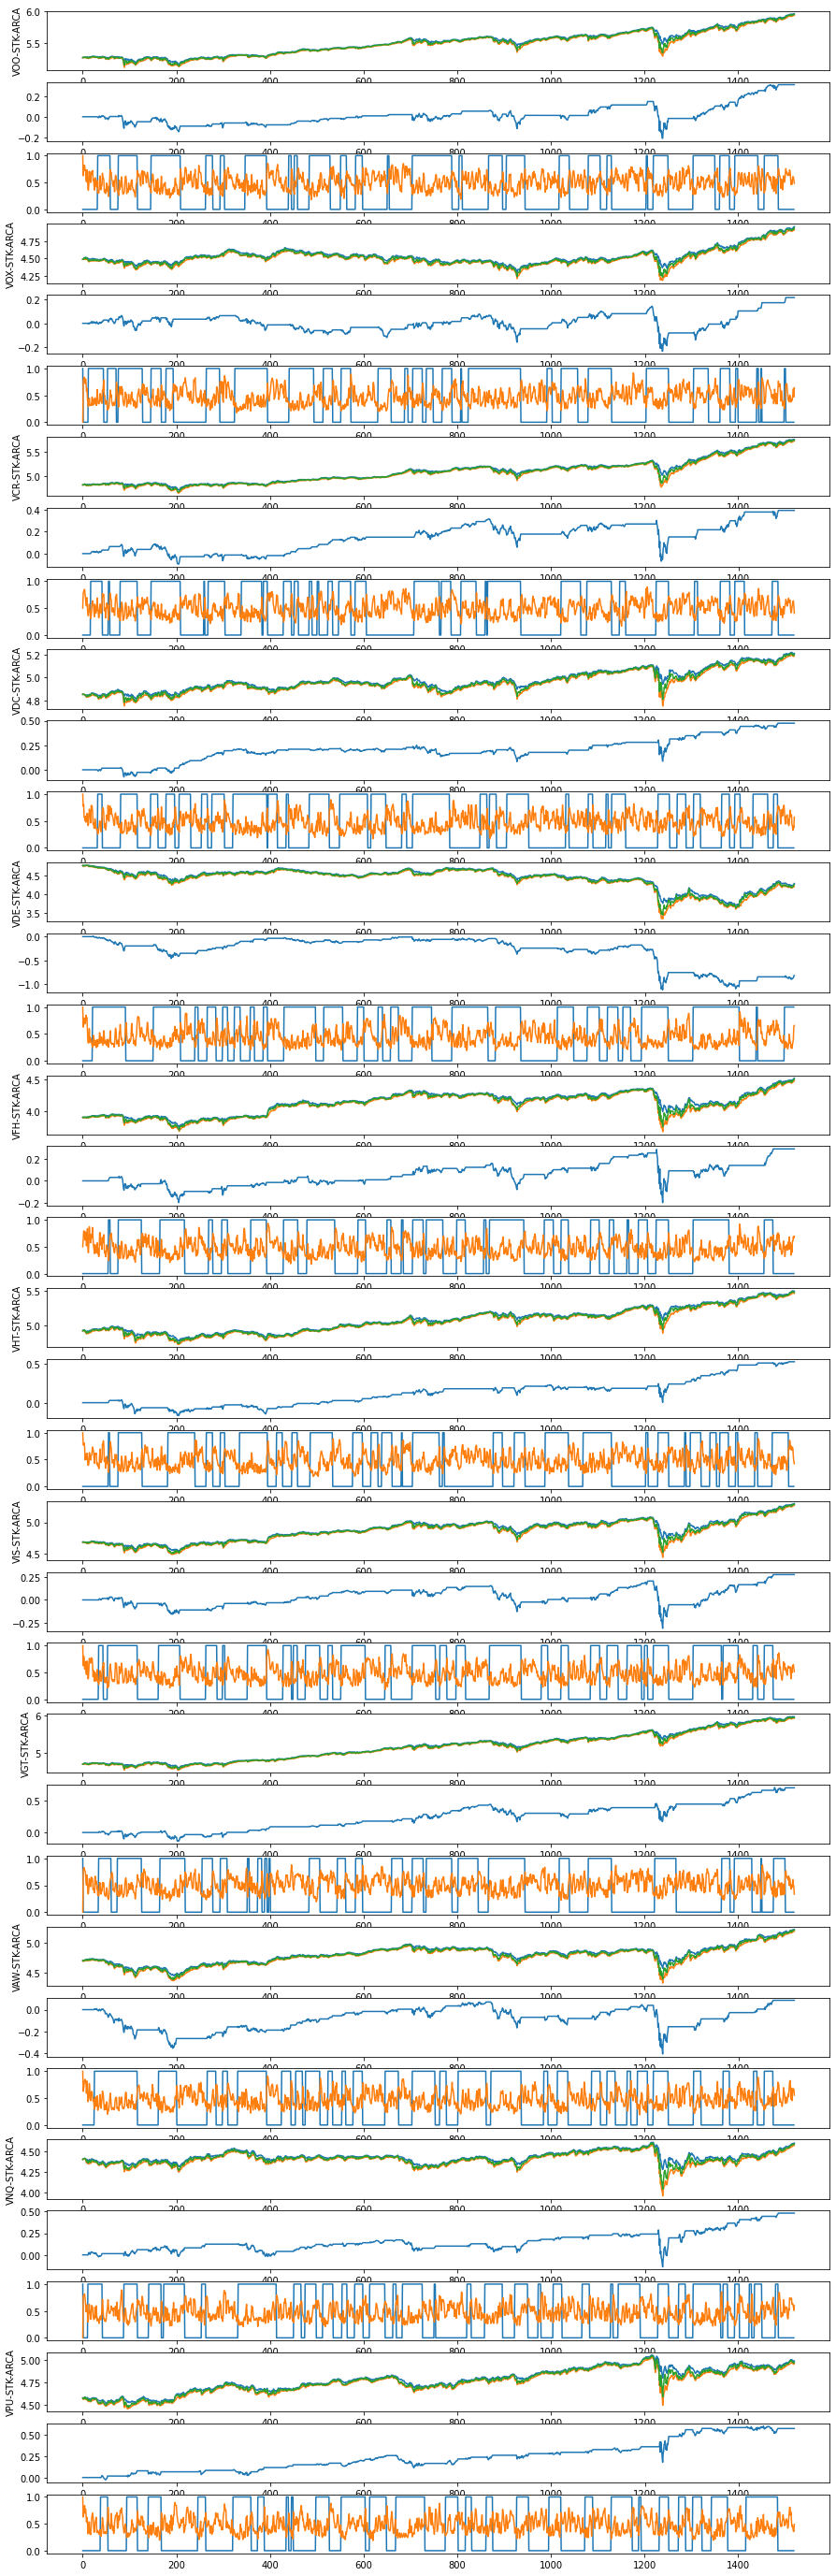

In [26]:
buy_s = 1.0*(s<np.percentile(s,10,0))[:-1,:]
sell_s = 1.0*(s>np.percentile(s,90,0))[:-1,:]

pos = buy_s[0,:]*0
poss = []
for t in range(len(buy_s)):
    pos = np.clip(pos + (1-pos)*buy_s[t,:]  - (pos)*sell_s[t,:],0,1)
    poss.append(pos)
poss = np.array(poss)

c = X_b[:,:,0]
r = c[1:,:]-c[:-1,:]

strat = np.cumsum(r*(poss),0)
 
plt.figure(figsize=(15,3))
plt.title(f"{sharpe(rets)} vs {sharpe(r)}");
plt.plot(strat.mean(1))
plt.figure(figsize=(15,50))
N = len(instruments)
S = 3
for i in range(N):
    plt.subplot(S*N,1,S*i+1)
    plt.ylabel(instruments[i]);
    plt.plot(nn[:,i,0])
    plt.plot(nn[:,i,1])
    plt.plot(X_b[:,i,0])
    plt.subplot(S*N,1,S*i+2)
    plt.plot(strat[:,i])
    plt.subplot(S*N,1,S*i+3)
    plt.plot(poss[:,i])
    plt.plot(s[:,i])
plt.show()


In [41]:
dfs['s'] = s.transpose().flatten()

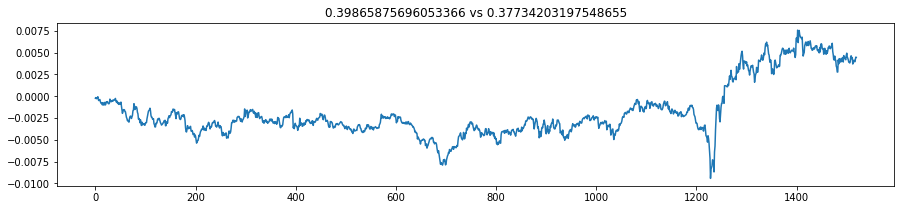

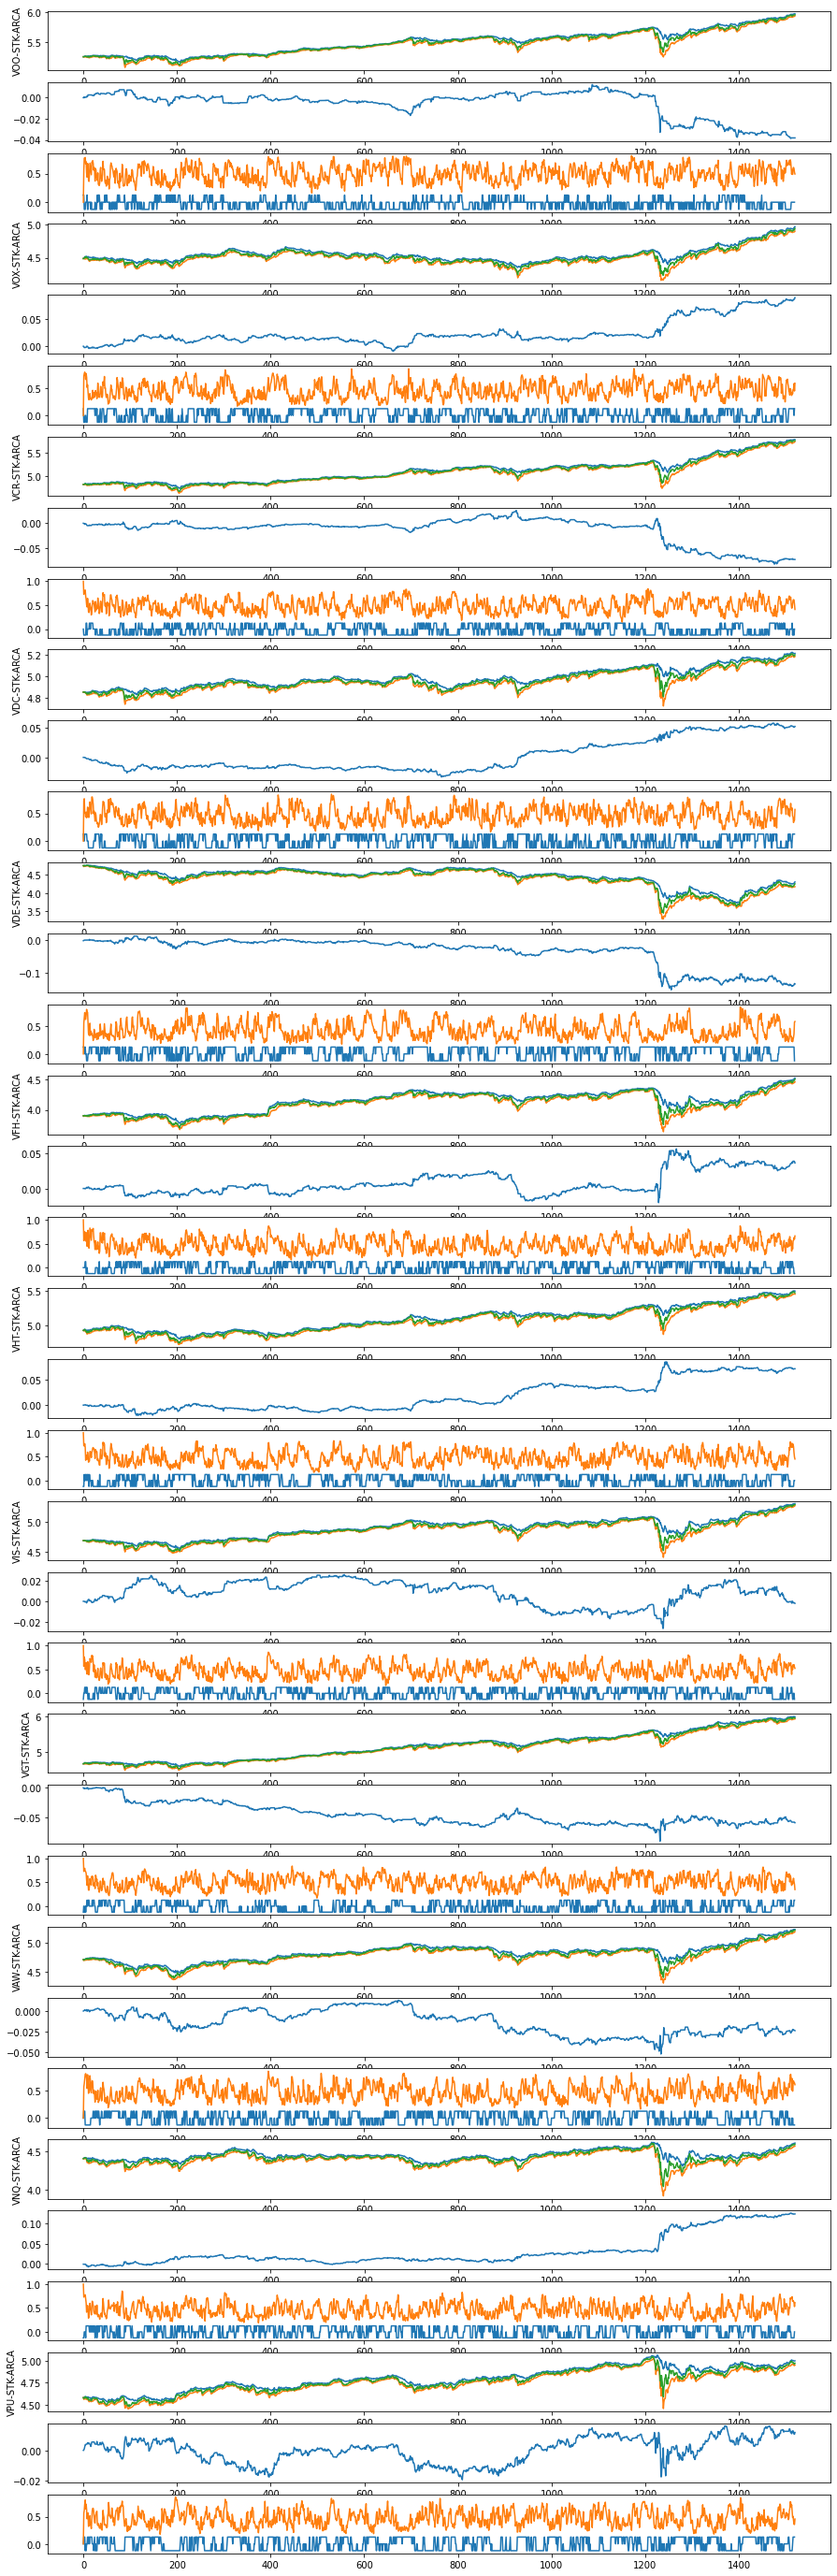

In [65]:
N_long = 4
N_short = 4
s_ = s[:-1,:]

beta = 0.5

ranking = np.argsort(s[:-1,:],1)
pos = (beta)*(1/N_long)*np.eye(s.shape[1])[ranking[:,:N_long]].sum(1) - (1-beta)*(1/N_short)*np.eye(s.shape[1])[ranking[:,-N_short:]].sum(1) 
strat = np.cumsum(r*(pos),0)

plt.figure(figsize=(15,3))
plt.title(f"{sharpe(rets)} vs {sharpe(r)}");
plt.plot(strat.mean(1))
plt.figure(figsize=(15,50))
N = len(instruments)
S = 3
for i in range(N):
    plt.subplot(S*N,1,S*i+1)
    plt.ylabel(instruments[i]);
    plt.plot(nn[:,i,0])
    plt.plot(nn[:,i,1])
    plt.plot(X_b[:,i,0])
    plt.subplot(S*N,1,S*i+2)
    plt.plot(strat[:,i])
    plt.subplot(S*N,1,S*i+3)
    plt.plot(pos[:,i])
    plt.plot(s[:,i])
plt.show()


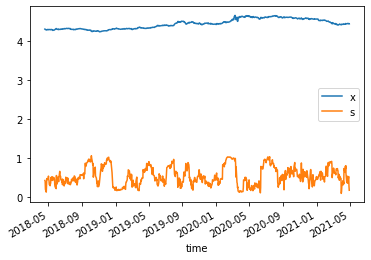

In [143]:
dfs.loc[instruments[0]][['x',"s"]].plot()

In [138]:
instruments[0]

'VGLT-STK-ARCA'

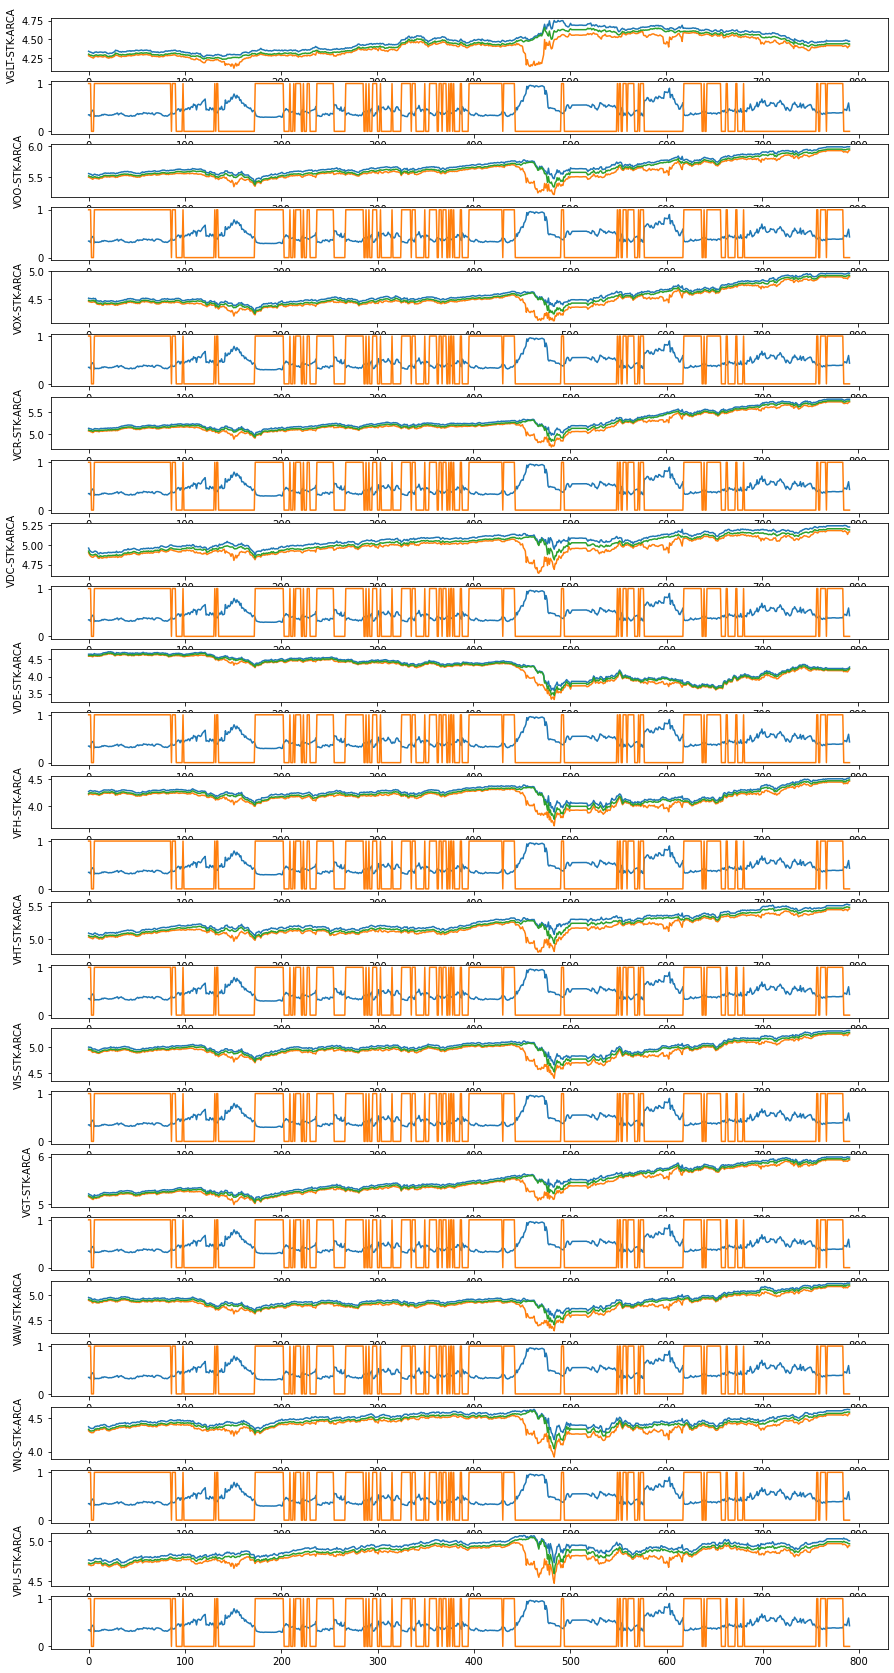

In [34]:
N = len(instruments)
n_tail=100
plt.figure(figsize=(15,30))
for i in range(N):
    plt.subplot(2*N,1,2*i+1)
    plt.ylabel(instruments[i]);
    plt.plot(nn[:,i,0])
    plt.plot(nn[:,i,1])
    plt.plot(X_b[:,i,0])
    plt.subplot(2*N,1,2*i+2)
    plt.plot(s[:-1,i])
    plt.plot((s[:-1,i]<0.4))
plt.show()

In [342]:
(w[:-1,:]*r).sum(1)

array([-3.62857342e-01, -3.59960169e-01, -3.19138646e-01, -4.28768069e-01,
       -6.62048876e-01, -4.57999825e-01, -4.63243544e-01, -4.31952029e-01,
       -3.85846466e-01, -3.61600399e-01, -3.95147324e-01, -3.91000718e-01,
       -3.85469288e-01, -4.17462468e-01, -3.47661018e-01, -3.58024508e-01,
       -3.60734582e-01, -3.39969784e-01, -3.41887504e-01, -3.36369663e-01,
       -3.51222545e-01, -3.46503764e-01, -3.33151728e-01, -3.59518260e-01,
       -3.73127341e-01, -3.54983121e-01, -3.57755542e-01, -3.29368830e-01,
       -3.11673939e-01, -3.24083686e-01, -2.99203277e-01, -3.23880583e-01,
       -3.39602530e-01, -3.31732631e-01, -3.07862431e-01, -3.19882721e-01,
       -3.09755713e-01, -2.92989641e-01, -3.09699923e-01, -2.98160046e-01,
       -2.95087934e-01, -3.05549562e-01, -2.86296636e-01, -2.79424131e-01,
       -2.75398314e-01, -2.90073156e-01, -3.05944502e-01, -2.94029057e-01,
       -3.97163540e-01, -2.89651781e-01, -3.11957687e-01, -3.61053765e-01,
       -3.53154540e-01, -

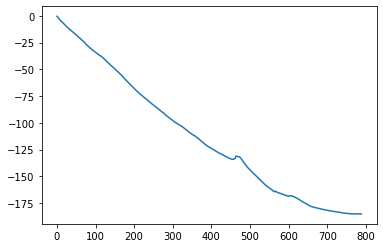

In [333]:
plt.plot(np.cumsum((w[:-1,:]*r).sum(1)))

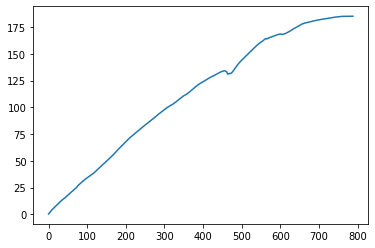

In [334]:
r = X_b[1:,:,0] - X_b[-1:,:,0]
plt.plot(np.cumsum(-1*(w[:-1,:]*r).sum(1)))

In [309]:
#([X_s[:-test_length,:,:],X_b[:-test_length,:,:]])#, Y[:-test_length,:,:],

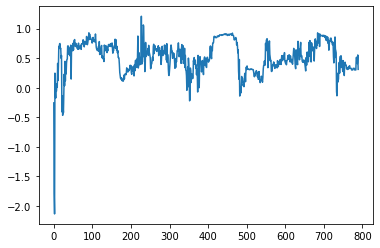

In [122]:
mx = nn[:,3,0]
mn = nn[:,3,1]
plt.plot((X[:,3,0]-mn)/(mx-mn))

In [110]:
df["nn_max"] = nn[:,0,:]
df["nn_min"] = nn[:,1,:]
plt.figure(figsize=(15,12));
N = 2
ax=plt.subplot(N,1,1);
df[["nn_max","nn_min",'close']].tail(300).plot(ax=ax);
ax=plt.subplot(N,1,2);
df[strats+["target_max","target_min"]].tail(300).plot(ax=ax);

NameError: name 'df' is not defined

In [28]:
x

NameError: name 'x' is not defined

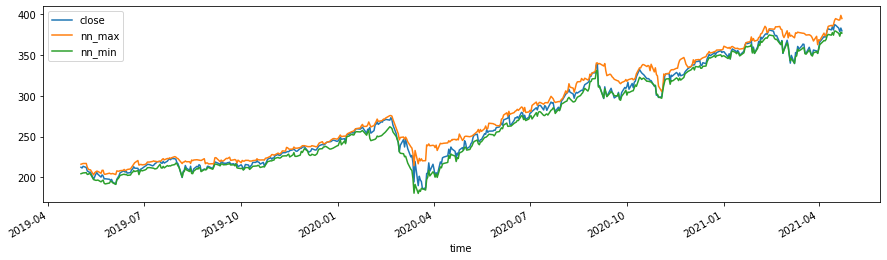

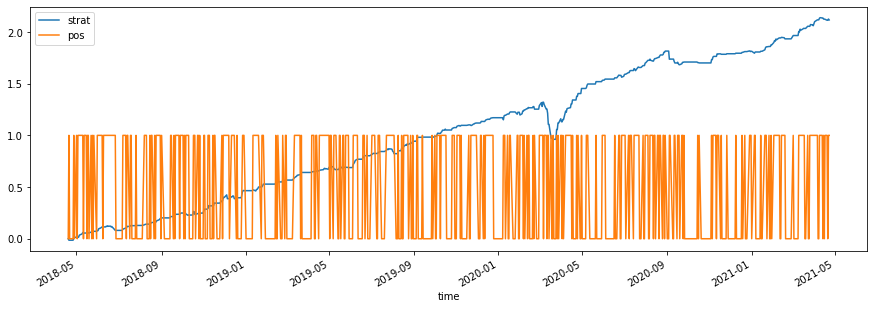

In [385]:
alpha = 4
beta = 0.1
nn_ = df['nn'].ewm(com=alpha)
buy_signal = 1.0*(df['nn'] > nn_.mean() - beta*nn_.std())
sell_signal = 1.0*(df['nn'] < nn_.mean() + beta*nn_.std())

pos = []
p = 0
for t in range(len(df["close"])):
    if p==0 and buy_signal[t]:
        p = 1
    elif p==1 and sell_signal[t]:
        p = 0
    pos.append(p)
df["pos"] = pos

df["r"] = df['close'].pct_change().fillna(0)
df["strat"] = (df["r"]*df["pos"]).cumsum()
df[['close',"nn_max","nn_min"]].tail(tail).plot(figsize=(15,4))
df[["strat","pos"]].plot(figsize=(15,5))